## TL;DR

This notebook is used to run experiments for offline data analysis section in the Aquarius paper. 

# Import & Utils

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from math import pi
import time
import datetime

from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import json
import math
import random

%matplotlib inline
min_max_scaler = preprocessing.MinMaxScaler()

sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

In [2]:
'''
write data to json file
'''
def json_write2file(data, filename):
    with open(filename, "w") as write_file:
        json.dump(data, write_file, indent=4) # w/ indent the file looks better

'''
read data from json file
'''
def json_read_file(filename):
    with open(filename, "r") as read_file:
        return json.load(read_file)
    
# @desc:   read lines from a file into a list
# @params: (str)filename
# @return: list of strings
def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404
    }

In [42]:
COLORS = ["#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]

MARKERS = ["o", "^", "*", "P"]

trace_types = [
    'PHP For-Loop', 
    'PHP File', 
    'Wiki',
    'Wiki (Flooded)'
]

color_map = {t: COLORS[i] for i,t in enumerate(trace_types)}
marker_map = {t: MARKERS[i] for i,t in enumerate(trace_types)}
fig_dir = '../../data/figures/atc/application/autoscale'

In [4]:
shm_layout = json_read_file("../../src/lb/shm_layout_base_dev.json")

feature_as_cnt = [_[1] for _ in shm_layout["vpp"]["struct"]["as_stat"][1:]] # counter features gathered for each AS in as_stat_t
feature_as_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_as"]] # features gathered for each AS w/ reservoir sampling
feature_lb_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_lb"]] # features gathered for LB node w/ reservoir sampling
RES_FEATURE_ENG = ["avg", "90", "std", "avg_decay", "90_decay"]
FEATURE_AS_ALL = feature_as_cnt + ["_".join((a, b)) for a in feature_as_res for b in RES_FEATURE_ENG]
# avg AS features and append LB features
FEATURE_LB_ALL = FEATURE_AS_ALL + \
    ["_".join((a, b)) for a in feature_lb_res for b in RES_FEATURE_ENG]
GT = ["cpu", "memory", "apache", "asid"]

# Table of Contents

1. Run experiments for three traces
2. Load datasets
3. Analyse correlations (section 4.1.1)
4. PCA Analysis (section 4.1.2)
5. Overhead analysis (section 4.1.3)

## Run Experiments

### Unit Test

In [5]:
import sys
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu

In [18]:
lb_method = 'ecmp'
trace='wiki_600'
experiment='atc-prediction'
sample='hour0.csv'
from_orig=None
config_file_prefix='2lb-conf00'
colocate=None
colocate_freq=0.0001
twist=False
clip_n=None
ep=0

In [19]:
server_id = 1
config_file = config_file_prefix+'-'+str(server_id)
config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0]}
ip_remote = tu.COMMON_CONF['net']['physical_server_ip']

task_name, task_dir, nodes = tu.init_task_info(
    experiment=experiment,
    lb_method=lb_method,
    trace=trace,
    sample=sample,
    filename=config_file+'.json',
    colocate=colocate,
    colocate_freq=colocate_freq,
    alias=config_file_prefix
)

print(">> run task {}".format(task_name))

init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour0-2lb-conf00


In [20]:
for server_id in [0]:
    if clip_n and server_id == 0:
        clip_str = '-n {}'.format(clip_n)
    else:
        clip_str = ''
    
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)
#     print(cmd)
    tu.subprocess.Popen(cmd, shell=True)

In [21]:
tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

Create LB node image...


In [22]:
tu.runall()
time.sleep(10)

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost


In [23]:
net_ok = False
while not net_ok:
    try:
        tu.gt_socket_check()
        net_ok = True
    except:
        print('error')
        time.sleep(1)

LB Node 0: pass


In [24]:
# start gathering at LB node
for lb in tu.NODES['lb']:
    lb.run_init_bg()
# run traffic
t0 = time.time()
cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
    experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])

tu.subprocess_cmd(cmd)
print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))


Trace replay over w/ total time: 641.140s


In [25]:
# fetch results from nodes
for server_id in [0]:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
    if server_id == 0:
        cmd += ' --shutdown'
    tu.subprocess.Popen(cmd, shell=True)
#     print(cmd)

In [26]:
for lb in tu.NODES['lb']:
    lb.fetch_result(task_dir, ep)

In [27]:
tu.shutall()

## Pipeline

In [29]:
def run_pipeline(
    lb_method = 'ecmp',
    trace='wiki_600',
    experiment='atc-prediction',
    sample='hour0.csv',
    from_orig=None,
    config_file_prefix='2lb-conf00',
    colocate=None,
    colocate_freq=0.0001,
    twist=False,
    clip_n=None,
    n_ep=1,
):
    server_id = 1
    config_file = config_file_prefix+'-'+str(server_id)
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0]}
    ip_remote = tu.COMMON_CONF['net']['physical_server_ip']
    
    for ep in range(n_ep):

        task_name, task_dir, nodes = tu.init_task_info(
            experiment=experiment,
            lb_method=lb_method,
            trace=trace,
            sample=sample,
            filename=config_file+'.json',
            colocate=colocate,
            colocate_freq=colocate_freq,
            alias=config_file_prefix
        )

        print(">> run task {}".format(task_name))

        for server_id in [0]:
            if clip_n and server_id == 0:
                clip_str = '-n {}'.format(clip_n)
            else:
                clip_str = ''

            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)
        #     print(cmd)
            tu.subprocess.Popen(cmd, shell=True)

        tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

        tu.runall()
        time.sleep(10)

        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)

        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()
        # run traffic
        t0 = time.time()
        cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])

        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))


        # fetch results from nodes
        for server_id in [0]:
            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
            if server_id == 0:
                cmd += ' --shutdown'
            tu.subprocess.Popen(cmd, shell=True)
        #     print(cmd)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, ep)

        tu.shutall()

In [30]:
samples = ['hour{}.csv'.format(i) for i in range(22)]
n_ep = 3
for sample in samples:
    run_pipeline(
        lb_method = 'ecmp',
        trace='wiki_600',
        experiment='atc-prediction',
        sample=sample,
        from_orig=None,
        config_file_prefix='2lb-conf00',
        colocate=None,
        colocate_freq=0.0001,
        twist=False,
        clip_n=None,
        n_ep=n_ep,
    )
    time.sleep(1)

init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour0-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 623.536s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour0-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 664.013s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour3-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhos

node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 601.986s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour7-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@loca

node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 602.003s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour10-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@loc

node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 601.912s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour13-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@loc

node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 601.889s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour17-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@lo

node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 602.016s
init_task_info: alias=2lb-conf00
alias=2lb-conf00
>> run task wiki_600-ecmp-hour20-2lb-conf00
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
LB Node 0: pass
Trace replay over w/ tot

## Load Training Dataset

In [5]:
## Clip Outliers

from scipy import stats
import numpy as np

def clip_outliers(X):
    X = np.array(X)
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    # X is the 1D data array
    z_scores = stats.zscore(X)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return X[filtered_entries]

def load_shm(filename, as_range, ep):
    global FEATURE_AS_ALL, GT
    min_max_scale = lambda x: (x - x.min()) / (x.max() - x.min())
    normalize = lambda x: (x - x.mean())/x.std()
    lines = read_file(filename)
    lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
    df_dict = {
        'ts': [],
        'asid': [],
        '#cpu': [],
        'ep': [],
    }
    df_dict.update({k: [] for k in FEATURE_AS_ALL})
    df_dict.update({k: [] for k in GT})
    t0 = 0
    ncpu = 1
    for l in lines:
        d = json.loads(l)
        if t0 == 0:
            t0 = d['ts']
            ts = 0
        else:
            ts = d['ts'] - t0
        for as_id in as_range:
            for i, k in enumerate(FEATURE_AS_ALL):
                df_dict[k].append(d['feature_as'][as_id][i])
            for i, k in enumerate(GT):
                df_dict[k].append(d['gt'][as_id][i])
            df_dict['#cpu'].append(ncpu)
            df_dict['ts'].append(ts)
    for k, v in df_dict.items():
        if k in ['asid', '#cpu']: continue
    df_dict['cpu usage'] = df_dict['cpu']
    df_dict['#thread'] = df_dict['apache']
    df_dict['ep'] = ep
    del(df_dict['cpu'])
    del(df_dict['apache'])
    return pd.DataFrame.from_dict(df_dict)

In [17]:
method = 'ecmp'
dfs = []
data_dir = '../../data/results/atc-prediction'

In [18]:
trace_type = 'Wiki'
server_range = range(1, 13)

In [19]:
wc_result = !wc -l ../../data/trace/wiki_600/*
rate_hour = {}
for wc in wc_result:
    if '.csv' in wc:
        n_line, hour = wc.strip(' ').strip('.csv').split(' ../../data/trace/wiki_600/hour')
        rate_hour[int(hour)] = int(n_line)/600

In [20]:
for hour, rate in {k: v for k, v in sorted(rate_hour.items(), key=lambda item: item[1])}.items():
    if hour in [22, 23]: continue # skip online prediction hours
    print("== process | {} - hour {} | rate={:.3f}/s |".format(trace_type, hour, rate))
    trace = 'hour{}-2lb-conf00'.format(hour)
    for lb in range(1):
        for ep in range(3):
            filename = "{}/wiki_600/{}/{}/{}_log_ep{}/shm.json".format(data_dir, method, trace, lb, ep)
            df = load_shm(filename, server_range, ep)
            # clip outliers
        #     df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
            dfs.append(df)
            dfs[-1]['Traffic Rate'] = rate

== process | Wiki - hour 11 | rate=359.210/s |
== process | Wiki - hour 12 | rate=369.805/s |
== process | Wiki - hour 10 | rate=376.670/s |
== process | Wiki - hour 13 | rate=390.742/s |
== process | Wiki - hour 14 | rate=402.472/s |
== process | Wiki - hour 9 | rate=423.540/s |
== process | Wiki - hour 15 | rate=435.248/s |
== process | Wiki - hour 8 | rate=518.793/s |
== process | Wiki - hour 16 | rate=520.987/s |
== process | Wiki - hour 7 | rate=617.438/s |
== process | Wiki - hour 17 | rate=642.720/s |
== process | Wiki - hour 3 | rate=683.293/s |
== process | Wiki - hour 2 | rate=687.440/s |
== process | Wiki - hour 4 | rate=690.855/s |
== process | Wiki - hour 6 | rate=696.502/s |
== process | Wiki - hour 5 | rate=712.993/s |
== process | Wiki - hour 18 | rate=731.530/s |
== process | Wiki - hour 20 | rate=758.782/s |
== process | Wiki - hour 21 | rate=759.283/s |
== process | Wiki - hour 1 | rate=761.340/s |
== process | Wiki - hour 19 | rate=767.995/s |
== process | Wiki - ho

In [21]:
def get_df_orig():
    global dfs
    df_all = pd.concat(dfs)
    df_all = df_all.fillna(0)
#     df_all = df_all.loc[df_all['memory']>0]
    return df_all

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [23]:
cols_all = list(df.columns)
col2plot = [col for col in cols_all if col not in ['ep', 'ts', 'cpu usage', 'memory', '#thread', 'asid', '#cpu', 'Traffic Rate', 'Trace']]
col2log = [col for col in cols_all if 'byte' in col or 'iat' in col or 'lat' in col]
row2plot = ['#cpu', 'cpu usage', '#thread', 'memory']

def get_preprocess_data(scaler_type='minmax'):
    df_all = get_df_orig()
    outlier_excluded_idx = (np.nan_to_num(np.abs(stats.zscore(df_all[col2plot]))) < 3)
    df_all = df_all[outlier_excluded_idx.all(axis=1)]
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_all.loc[:, col2log] = np.log(np.array(df_all.loc[:, col2log]+1e-6))
    df_all.loc[:, col2plot] = scaler.fit_transform(np.array(df_all.loc[:, col2plot]))
    return df_all, scaler

In [24]:
df_all, scaler = get_preprocess_data(scaler_type='std')

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [25]:
label_min_max_scaler = MinMaxScaler()
df_all.loc[:, ['memory', '#thread']] = label_min_max_scaler.fit_transform(df_all.loc[:, ['memory', '#thread']].values)

## Feature Scale

-- Wiki --


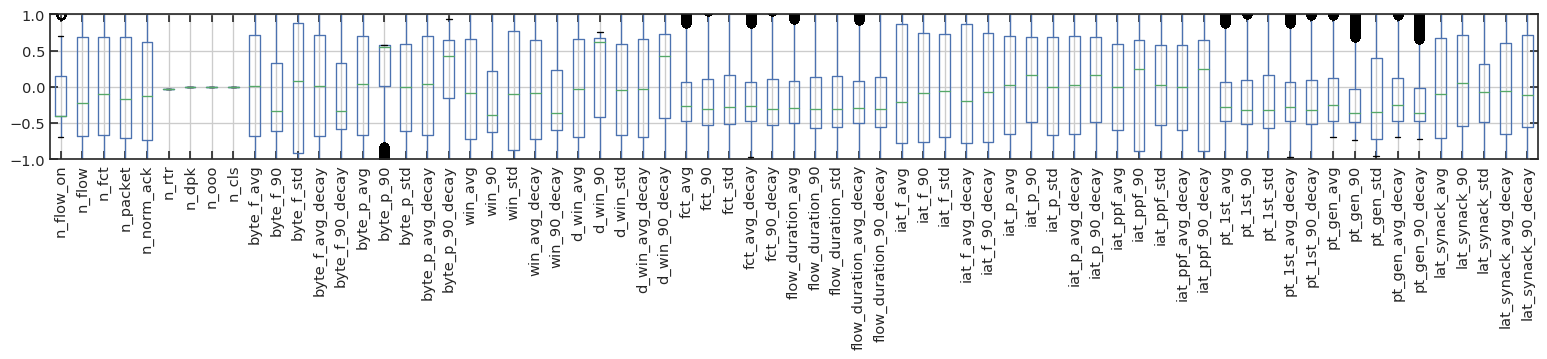

In [26]:
trace = 'Wiki'
print("-- {} --".format(trace))
plt.figure(figsize=(20,2), dpi=96)
df_all.boxplot(column=col2plot)
plt.xticks(rotation=90)
plt.ylim(-1, 1)
plt.show()

In [27]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_parallel(
  df, key_col, cols2plot, x_col=None, 
  figsize=(6,3), dpi=96, 
  xlabel=None, ylabel=None, title=None, 
  logx=False, logy=False, xlim=None, ylim=None, save2filename=None, smoothbox=10):
    '''
    @params:
    df: a pandas dataframe w/ columns: [key_col, x_col, *cols2plot]
    key_col: name of the key column (like 'as_id' above)
    x_col: column as the x axis (like 'ts' above)
    cols2plot: columns to plot (like 'pt_1st_avg', 'pt_gen_avg', 'apache' above)
    '''
    keys = range(2,11)
    
    fig, axs = plt.subplots(len(keys), figsize=figsize, dpi=dpi, sharex=True)
    for i, ax in zip(keys, axs):
        df_local = df.loc[df[key_col] == i]
        for col in cols2plot:
            if i == 0:
                df_local = df_local.iloc[::2]
            if x_col:
                ax.plot(df_local[x_col], smooth(df_local[col].values, smoothbox), label=col)
            else:
                ax.plot(smooth(df_local[col].values, smoothbox), label=col)
#     plt.legend()
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title)
    if logy: plt.yscale('log')
    if logx: plt.xscale('log')
    if save2filename: fig.savefig(save2filename, bbox_inches='tight', transparent=True)
#     plt.show()
    return fig, axs

Text(0.5, 0, 'Time Step')

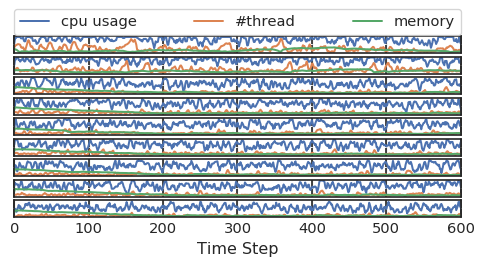

In [135]:
# plot timeline
fig, axs = plot_parallel(df_all.loc[(df_all['Traffic Rate'] > 750)], 'asid', ['cpu usage', '#thread', 'memory'], figsize=(6, 2.5), xlim=(0, 600), smoothbox=3)
for ax in axs:
    ax.yaxis.set_ticks([])
axs[0].legend(bbox_to_anchor=(0.,1.06,1,0.2), loc="lower left",
                ncol=3, borderaxespad=0, mode='expand')
axs[-1].set_xlabel('Time Step')

# Checkpoint: Get all X and y data in a backup

In [28]:
df_all.head()

,ts,asid,#cpu,ep,n_flow_on,n_flow,n_fct,n_packet,n_norm_ack,n_rtr,...,pt_gen_90_decay,lat_synack_avg,lat_synack_90,lat_synack_std,lat_synack_avg_decay,lat_synack_90_decay,memory,cpu usage,#thread,Traffic Rate
0,0.0,11.0,1,0,-0.128477,-1.026279,-1.120788,-1.041712,-0.926557,-0.024568,...,-0.474679,0.547310,0.709567,-0.042889,0.218721,0.189829,0.062259,0.315789,0.00000,359.21
1,0.0,10.0,1,0,-0.685612,-0.911747,-0.894751,-0.874400,-0.727766,-0.024568,...,-0.597795,0.912778,0.709567,0.422241,0.876658,0.964032,0.065382,0.150000,0.03125,359.21
2,0.0,9.0,1,0,-0.407045,-1.369877,-1.346826,-1.376335,-1.274442,-0.024568,...,-0.347275,1.286060,1.265826,0.268161,0.812548,0.938958,0.969592,0.650000,0.03125,359.21
4,0.0,7.0,1,0,-0.685612,-1.369877,-1.233807,-1.283384,-1.075651,-0.024568,...,-0.492892,1.194263,1.265826,0.553238,0.851716,1.387150,0.984792,0.476190,0.00000,359.21
5,0.0,6.0,1,0,-0.407045,-1.484410,-1.572863,-1.487876,-1.324140,-0.024568,...,-0.389584,1.217305,0.709567,0.084446,0.979084,0.856407,0.990190,0.450000,0.03125,359.21


In [30]:
df_all.to_csv('../../data/results/atc-prediction/wiki_600/ecmp/checkpoint.csv')

In [31]:
!du -h ../../data/results/atc-prediction/wiki_600/ecmp/checkpoint.csv

1013M	../../data/results/atc-prediction/wiki_600/ecmp/checkpoint.csv


In [32]:
df_all_backup = df_all.copy()

In [9]:
df_all = pd.read_csv('../../data/results/atc-prediction/wiki_600/ecmp/checkpoint.csv')
cols_all = list(df_all.columns)
col2plot = [col for col in cols_all if col not in ['cpu usage', 'memory', '#thread', 'asid', '#cpu', 'Traffic Rate', 'Trace']]
col2log = [col for col in cols_all if 'byte' in col or 'iat' in col or 'lat' in col]
row2plot = ['#cpu', 'cpu usage', '#thread', 'memory']

# Make Predictions happen!

In [75]:
# helper functions
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import keras

def plot_series(series, y=None, y_pred=None, x_label="Time (s)", y_label="CPU Usage", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "go", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -0.01, 1.01])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

def plot_multiple_forecasts(X, Y, Y_pred, filename=None, state=0):
    if state > X.shape[0]:
        state = np.random.randint(X.shape[0])
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    f = plt.figure(figsize=(4,2), dpi=96)
    plot_series(X[state, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[state, :], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[state, :], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, 0.5, 1.01])
    plt.legend(loc="lower left")
    if filename:
        f.savefig('{}/{}'.format(fig_dir, filename), bbox_inches='tight', transparent=True)

def last_time_step_metric(Y_true, Y_pred):
    mse = keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    rmse = np.sqrt(mse)
    mae = keras.metrics.mean_absolute_error(Y_true[:, -1], Y_pred[:, -1])
    return np.mean(mse), np.mean(rmse), np.mean(mae)

def first_time_step_metric(Y_true, Y_pred):
    mse = keras.metrics.mean_squared_error(Y_true[:, 0], Y_pred[:, 0])
    rmse = np.sqrt(mse)
    mae = keras.metrics.mean_absolute_error(Y_true[:, 0], Y_pred[:, 0])
    return np.mean(mse), np.mean(rmse), np.mean(mae)

def seq_register_display_scores(y, y_pred, model_name):
    global score_board
    mse = np.mean(keras.metrics.mean_squared_error(y, y_pred))
    rmse = np.sqrt(mse)
    mae = np.mean(keras.metrics.mean_absolute_error(y, y_pred))
    first_mse, first_rmse, first_mae = first_time_step_metric(y, y_pred)
    last_mse, last_rmse, last_mae = last_time_step_metric(y, y_pred)
    res = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'first_step_mse': first_mse,
        'first_step_rmse': first_rmse,
        'first_step_mae': first_mae,
        'last_step_mse': last_mse,
        'last_step_rmse': last_rmse,
        'last_step_mae': last_mae,
    }
    print("=== {} ===".format(model_name))
    for k, v in res.items():
        print("{}: {:6f}".format(k, v))
    score_board[model_name] = res

## Non Sequential Feature Selection

In [40]:
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_regression, f_regression

In [43]:
%%timeit
selection = SelectPercentile(f_regression, percentile=20)
feature_new = selection.fit_transform(X_non_sequential, Y_non_sequential)
support = np.asarray(selection.get_support())
columns_with_support = np.array(col2plot)[support]

/home/yzy/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yzy/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (

411 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
columns_with_support

array(['n_flow_on', 'flow_duration_avg', 'flow_duration_90',
       'flow_duration_std', 'flow_duration_avg_decay',
       'flow_duration_90_decay', 'iat_f_avg', 'iat_f_avg_decay',
       'iat_p_std', 'iat_ppf_avg', 'iat_ppf_std', 'iat_ppf_avg_decay',
       'pt_1st_90', 'pt_1st_90_decay'], dtype='<U23')

In [45]:
%%timeit
selection = SelectPercentile(mutual_info_regression, percentile=20)
feature_new = selection.fit_transform(X_non_sequential, Y_non_sequential)
support = np.asarray(selection.get_support())
columns_with_support = np.array(col2plot)[support]

/home/yzy/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yzy/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yzy/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yzy/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

16min 16s ± 5.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
cols_non_seq = set(['fct_std', 'fct_avg_decay', 'fct_90_decay', 'flow_duration_std',
       'flow_duration_avg_decay', 'flow_duration_90_decay',
       'iat_f_avg_decay', 'iat_ppf_std', 'iat_ppf_avg_decay',
       'iat_ppf_90_decay', 'pt_1st_std', 'pt_1st_avg_decay',
       'pt_1st_90_decay', 'pt_gen_90_decay']+['n_flow_on', 'flow_duration_avg', 'flow_duration_90',
       'flow_duration_std', 'flow_duration_avg_decay',
       'flow_duration_90_decay', 'iat_f_avg', 'iat_f_avg_decay',
       'iat_p_std', 'iat_ppf_avg', 'iat_ppf_std', 'iat_ppf_avg_decay',
       'pt_1st_90', 'pt_1st_90_decay'])

In [172]:
cols_non_seq

{'fct_90_decay',
 'fct_avg_decay',
 'fct_std',
 'flow_duration_90',
 'flow_duration_90_decay',
 'flow_duration_avg',
 'flow_duration_avg_decay',
 'flow_duration_std',
 'iat_f_avg',
 'iat_f_avg_decay',
 'iat_p_std',
 'iat_ppf_90_decay',
 'iat_ppf_avg',
 'iat_ppf_avg_decay',
 'iat_ppf_std',
 'n_flow_on',
 'pt_1st_90',
 'pt_1st_90_decay',
 'pt_1st_avg_decay',
 'pt_1st_std',
 'pt_gen_90_decay'}

# Prepare dataset

In [38]:
def generate_time_series(df_all, features, targets, n_step_x=32, n_step_y=1, stride=16):
    X_seq = []
    X_seq_y = []
    y_seq = []
    n_steps = n_step_x + n_step_y
    # identify episode by traffic rate, episode
    traffic_rates = df_all['Traffic Rate'].unique()
    for traffic_rate in traffic_rates:
        df_rate = df_all.loc[df_all['Traffic Rate'] == traffic_rate]
        for ep in df_rate.ep.unique():
            df_rate_ep = df_rate.loc[df_rate['ep'] == ep]
            for asid in df_rate_ep.asid.unique():
                df_rate_ep_asid = df_rate_ep.loc[df_rate_ep['asid'] == asid]
                df_len = len(df_rate_ep_asid)
                if df_len < n_steps: continue
                df_len -= n_steps
                i = 0
                df_rate_ep_asid.loc[:, targets] = smooth(df_rate_ep_asid.loc[:, targets].values.reshape(-1), smooth_level)
                while i < df_len:
                    X_seq.append(df_rate_ep_asid.iloc[i:i+n_step_x][features].values)
                    X_seq_y.append(df_rate_ep_asid.iloc[i:i+n_step_x][targets].values)
                    y_seq.append(df_rate_ep_asid.iloc[i+n_step_x:i+n_steps][targets].values)
                    i += stride
    return np.array(X_seq), np.array(X_seq_y), np.array(y_seq)

def prepare_data(features, n_step_y):
    targets = ['cpu usage']
    n_step_x = 32
    n_steps = n_step_x + n_step_y
    stride = 16
    smooth_level = 8
    train_percent = 0.7
    val_percent = 0.2
    test_percent = 0.1

    X_seq, X_seq_y, y_seq = generate_time_series(df_all, features, targets, n_step_x=n_step_x, n_step_y=n_step_y, stride=stride)
    

    total_len = X_seq.shape[0]

    X_train, X_train_y, y_train = X_seq[:int(train_percent*total_len)], X_seq_y[:int(train_percent*total_len)], y_seq[:int(train_percent*total_len)].reshape(-1, n_step_y)
    X_valid, X_valid_y, y_valid = X_seq[int(train_percent*total_len):int((train_percent+val_percent)*total_len)], X_seq_y[int(train_percent*total_len):int((train_percent+val_percent)*total_len)], y_seq[int(train_percent*total_len):int((train_percent+val_percent)*total_len)].reshape(-1, n_step_y)
    X_test, X_test_y, y_test = X_seq[-int(test_percent*total_len):], X_seq_y[-int(test_percent*total_len):], y_seq[-int(test_percent*total_len):].reshape(-1, n_step_y)

    X_train_non_seq = X_train[:, -1, :].reshape(-1, len(features))
    X_valid_non_seq = X_valid[:, -1, :].reshape(-1, len(features))
    X_test_non_seq = X_test[:, -1, :].reshape(-1, len(features))
    
    return (X_train, X_train_y, y_train), (X_valid, X_valid_y, y_valid), (X_test, X_test_y, y_test), (X_train_non_seq, X_valid_non_seq, X_test_non_seq)

## Predict 8 steps ahead

In [115]:
features = cols_non_seq

In [116]:
(X_train, X_train_y, y_train), (X_valid, X_valid_y, y_valid), (X_test, X_test_y, y_test), (X_train_non_seq, X_valid_non_seq, X_test_non_seq) = prepare_data(cols_non_seq, 8)

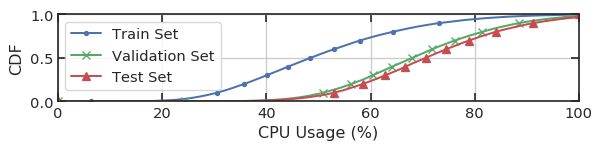

In [108]:
fig = plt.figure(figsize=(7, 1.2), dpi=96)

for values, color, marker, label in zip([y_train, y_valid, y_test], ['b', 'g', 'r'], ['.', 'x', '^'], ['Train Set', 'Validation Set', 'Test Set']):
    v = values.reshape(-1)*100
    percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker,color=color)
    plt.plot(0, 0, marker=marker, color=color, label=label)

plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('CPU Usage (%)')
plt.ylabel('CDF')
# plt.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
#            ncol=3, mode="expand", borderaxespad=0.)
plt.legend()
plt.show()

In [37]:
fig.savefig('../../data/figures/atc/application/autoscale/target-distribution.pdf', bbox_inches='tight', transparent=True)

# Regression Models

In [120]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import keras
import tensorflow as tf
import xgboost

from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

# naive
def test_naive(test_name, n_step_y):
    global score_board
    # take the last time step value and repeat it ${n_step_y} times
    model_name = 'Naive'
    y_pred = np.tile(X_test_y[:, -1], n_step_y)
    seq_register_display_scores(y_test, y_pred, model_name)
    time_res = %timeit -n 50 -r 10 -p 5 -o np.tile(X_test_y[:256, -1], n_step_y)
    score_board[model_name].update({
        'predict_t_avg': time_res.average*1e3,
        'predict_t_std': time_res.stdev*1e3,
    })
    plot_multiple_forecasts(X_test_y, y_test, y_pred, state=4242, filename='{}-{}.pdf'.format(test_name, model_name))

# non sequential
def test_non_seq(test_name):
    global score_board
    for model_name, model in {
        "Linear Regression": MultiOutputRegressor(LinearRegression()),
        "Ridge Regression": MultiOutputRegressor(Ridge()),
        "Decision Tree": MultiOutputRegressor(DecisionTreeRegressor(random_state=42)),
        "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
        "SVR (Linear)": MultiOutputRegressor(SVR(kernel='linear')),
        "SVR (RBF)": MultiOutputRegressor(SVR(kernel='rbf')),
        "XGBoost": MultiOutputRegressor(xgboost.XGBRegressor(random_state=42)),
    }.items():
        np.random.seed(42)
        tf.random.set_seed(42)
        model.fit(X_train_non_seq, y_train)
        y_pred = model.predict(X_test_non_seq)
        seq_register_display_scores(y_test, y_pred, model_name)
        time_res = %timeit -n 50 -r 10 -p 5 -o model.predict(X_test_non_seq[:256])
        score_board[model_name].update({
            'predict_t_avg': time_res.average*1e3,
            'predict_t_std': time_res.stdev*1e3,
        })
        plot_multiple_forecasts(X_test_y, y_test, y_pred, state=4242, filename='{}-{}.pdf'.format(test_name, model_name))

# sequential model
def test_seq(test_name):
    global score_board
    n_step_y = y_test.shape[1]
    for model_name, model in {
        "RNN": keras.models.Sequential([
                            keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, len(features)]),
                            keras.layers.SimpleRNN(20),
                            keras.layers.Dense(n_step_y)]),
        "RNN (Batch)": keras.models.Sequential([
                            keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, len(features)]),
                            keras.layers.BatchNormalization(),
                            keras.layers.SimpleRNN(20),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dense(n_step_y)
                        ]),
        "RNN (Layer)": keras.models.Sequential([
                            keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, len(features)]),
                            keras.layers.RNN(LNSimpleRNNCell(20)),
                            keras.layers.Dense(n_step_y)
                        ]),
        "LSTM": keras.models.Sequential([
                            keras.layers.LSTM(20, return_sequences=True, input_shape=[None, len(features)]),
                            keras.layers.LSTM(20, return_sequences=False),
                            keras.layers.Dense(n_step_y)
                        ]),
        "GRU": keras.models.Sequential([
                            keras.layers.GRU(20, return_sequences=True, input_shape=[None, len(features)]),
                            keras.layers.GRU(20, return_sequences=False),
                            keras.layers.Dense(n_step_y)
                        ]),
        "GRU+1dConv": keras.models.Sequential([
                            keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                                                input_shape=[None, len(features)]),
                            keras.layers.GRU(20, return_sequences=True),
                            keras.layers.GRU(20),
                            keras.layers.Dense(n_step_y)
                        ]),
        "WaveNet": keras.models.Sequential([
                            keras.layers.InputLayer(input_shape=[None, len(features)]),
                            keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=1),
                            keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=2),
                            keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=4),
                            keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=1),
                            keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=2),
                            keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=4),
                            keras.layers.GRU(20),
                            keras.layers.Dense(n_step_y),
                        ]),
    }.items():
        np.random.seed(42)
        tf.random.set_seed(42)
        model.compile(loss="mse", optimizer="adam")
        history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
        y_pred = model.predict(X_test)
        seq_register_display_scores(y_test, y_pred, model_name)
        time_res = %timeit -n 50 -r 10 -p 5 -o model.predict(X_test[:256])
        score_board[model_name].update({
            'predict_t_avg': time_res.average*1e3,
            'predict_t_std': time_res.stdev*1e3,
        })
        plot_multiple_forecasts(X_test_y, y_test, y_pred, state=4242, filename='{}-{}.pdf'.format(test_name, model_name))


In [98]:
test_name = 'non-seq-8'
score_board = {}

=== Naive ===
mse: 0.012226
rmse: 0.110573
mae: 0.083336
first_step_mse: 0.002109
first_step_rmse: 0.045929
first_step_mae: 0.035040
last_step_mse: 0.022306
last_step_rmse: 0.149351
last_step_mae: 0.118921
25.642 µs ± 1.0683 µs per loop (mean ± std. dev. of 10 runs, 50 loops each)


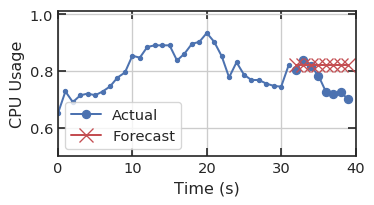

In [99]:
# Naive
test_naive(test_name, 8)

=== Linear Regression ===
mse: 0.015814
rmse: 0.125754
mae: 0.100383
first_step_mse: 0.013874
first_step_rmse: 0.117786
first_step_mae: 0.092162
last_step_mse: 0.017598
last_step_rmse: 0.132658
last_step_mae: 0.106395
1.4287 ms ± 379.72 µs per loop (mean ± std. dev. of 10 runs, 50 loops each)
=== Ridge Regression ===
mse: 0.015813
rmse: 0.125748
mae: 0.100435
first_step_mse: 0.013838
first_step_rmse: 0.117633
first_step_mae: 0.092324
last_step_mse: 0.017587
last_step_rmse: 0.132614
last_step_mae: 0.106379
1.3754 ms ± 294.46 µs per loop (mean ± std. dev. of 10 runs, 50 loops each)
=== Decision Tree ===
mse: 0.031919
rmse: 0.178659
mae: 0.141091
first_step_mse: 0.024204
first_step_rmse: 0.155577
first_step_mae: 0.121351
last_step_mse: 0.035968
last_step_rmse: 0.189652
last_step_mae: 0.150427
1.7646 ms ± 13.208 µs per loop (mean ± std. dev. of 10 runs, 50 loops each)
=== Random Forest ===
mse: 0.016235
rmse: 0.127416
mae: 0.100902
first_step_mse: 0.012377
first_step_rmse: 0.111252
first_s

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[22:17:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
=== XGBoost ===
mse: 0.015656
rmse: 0.125123
mae: 0.098911
first_step_mse: 0.011817
first_step_rmse: 0.108707
first_step_mae: 0.085435
last_step_mse: 0.018378
last_step_rmse: 0.135566
last_step_mae: 0.107969
5.3148 ms ± 287.73 µs per loop (mean ± std. dev. of 10 runs, 50 loops each)


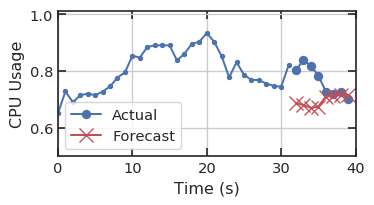

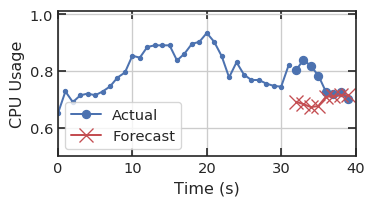

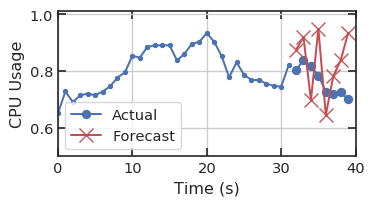

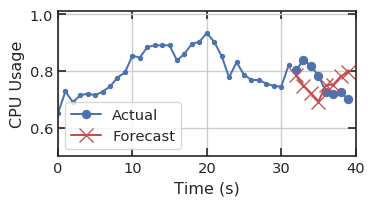

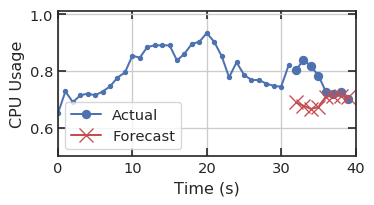

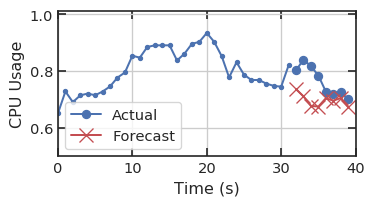

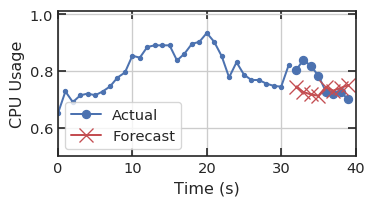

In [102]:
test_non_seq(test_name)

In [ ]:
test_seq(test_name)

Epoch 1/20
997/997 [==============================] - 21s 19ms/step - loss: 0.0436 - val_loss: 0.0161
Epoch 2/20
997/997 [==============================] - 16s 16ms/step - loss: 0.0119 - val_loss: 0.0153
Epoch 3/20
997/997 [==============================] - 16s 16ms/step - loss: 0.0112 - val_loss: 0.0140
Epoch 4/20
997/997 [==============================] - 17s 17ms/step - loss: 0.0108 - val_loss: 0.0137
Epoch 5/20
997/997 [==============================] - 16s 16ms/step - loss: 0.0105 - val_loss: 0.0135
Epoch 6/20
997/997 [==============================] - 15s 15ms/step - loss: 0.0104 - val_loss: 0.0127
Epoch 7/20
997/997 [==============================] - 16s 16ms/step - loss: 0.0102 - val_loss: 0.0127
Epoch 8/20
997/997 [==============================] - 15s 15ms/step - loss: 0.0101 - val_loss: 0.0125
Epoch 9/20
997/997 [==============================] - 17s 17ms/step - loss: 0.0100 - val_loss: 0.0120
Epoch 10/20
997/997 [==============================] - 17s 17ms/step - loss: 0.010

In [ ]:
score_board_all = {test_name: score_board}

In [152]:
for k, v in score_board_all.items():
    pd.DataFrame.from_dict(v).to_csv('../../data/results/atc-prediction/score-{}.csv'.format(k), sep=',', encoding='utf-8')

In [ ]:
score_board_all.loc[[]]

In [165]:
pd.options.display.float_format = '{:.3f}'.format

In [171]:
for k, v in score_board_all.items():
    print("=== {} ===".format(k))
    df = pd.DataFrame.from_dict(v)
    df.loc[[i for i in df.index if 'rmse' in i or 'mae' in i],:] = df.loc[[i for i in df.index if 'rmse' in i or 'mae' in i], :].values*100
    print(df.loc[[i for i in df.index if 'rmse' in i or 'mae' in i or 'predict' in i], :])

=== non-seq-8 ===
                 Naive  Linear Regression  Ridge Regression  Decision Tree  \
first_step_mae   3.504              9.216             9.232         12.135   
first_step_rmse  4.593             11.779            11.763         15.558   
last_step_mae   11.892             10.640            10.638         15.043   
last_step_rmse  14.935             13.266            13.261         18.965   
mae              8.334             10.038            10.044         14.109   
predict_t_avg    0.026              1.429             1.375          1.765   
predict_t_std    0.001              0.380             0.294          0.013   
rmse            11.057             12.575            12.575         17.866   

                 Random Forest  SVR (Linear)  SVR (RBF)  XGBoost    RNN  \
first_step_mae           8.717         9.255      9.040    8.544  7.903   
first_step_rmse         11.125        11.876     11.395   10.871 10.030   
last_step_mae           11.009        10.683     11.20